# Dynamic Pricing Model Using Thompson Sampling
We implement a dynamic price optimization model for descrete price levels using Thompson sampling.

### Data
We use an internal simulator. No external datasets are used.

### Papers
1. Ferreira K., Simchi-Levi D., and Wang H. -- Online Network Revenue Management Using Thompson Sampling, November 2017

In [1]:
!pip install tabulate

In [2]:
import numpy as np
from tabulate import tabulate
from scipy.optimize import linprog
import scipy.stats as stats 
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.animation as animation

np.set_printoptions(precision=2)

def tabprint(msg, A):
    print(msg)
    print(tabulate(A, tablefmt="fancy_grid"))
    
plt.rcParams.update({'font.family':'Candara', 'font.serif':['Candara']})
plt.rcParams.update({'pdf.fonttype': 'truetype', 'font.size': 18})

In [3]:
import numpy as np
import pandas as pd

# We import the sk learn modules we'll need to segment our new data. We'll need scaler, pca and k-means.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# We import pickle in order to be able to load our pickled objects.
import pickle

#We import the necessary libraries for visualization. We set seaborn do be our default.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Step 1: Determine Optimal Prices Using Numerical Optimization

In [34]:
# Find the optimal distribution of prices (price probabilities) given fixed price levels, 
# corresponding demand levels, and availbale product inventory.
# 
# Inputs:
#   prices, demands, and revenues are vectors (i-th element corresponds to i-th price level)
#   inventory is a scalar (number of availbale units)
def optimal_price_probabilities(prices, demands, inventory):   
    revenues = np.multiply(prices, demands)
    
    L = len(prices)
    M = np.full([1, L], 1)
    B = [[1]]
    Df = [demands]

    res = linprog(-np.array(revenues).flatten(), 
                  A_eq=M, 
                  b_eq=B, 
                  A_ub=Df, 
                  b_ub=np.array([inventory]), 
                  bounds=(0, None))

    price_prob = np.array(res.x).reshape(1, L).flatten()
    return price_prob

In [31]:
df_purchase = pd.read_csv('../data/purchase_data.csv')
df_purchase_incidence = df_purchase[df_purchase['Incidence'] == 1]
# brand_dummies = pd.get_dummies(df_purchase_incidence['Brand'], prefix = 'Brand', prefix_sep = '_')
# brand_dummies
df_brand1 = df_purchase_incidence[df_purchase_incidence['Brand'] == 1]
df_brand1.drop(['Incidence', 'Brand'], axis =1,inplace = True)
df_brand1['total_revenue'] = df_brand1['Quantity']*df_brand1['Price_1']
a = df_brand1.groupby('Price_1')['total_revenue'].sum()
price = a.index.to_list()
revenue = a.to_list()
revenue = [round(x, 2) for x in revenue]
print(price, len(price))
print(revenue, len(revenue))

[1.1, 1.14, 1.17, 1.19, 1.2, 1.21, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4, 1.41, 1.42, 1.43, 1.44, 1.46, 1.47, 1.48, 1.49, 1.5, 1.51] 34
[52.8, 91.2, 63.18, 408.17, 54.0, 232.32, 99.63, 17.36, 67.5, 415.8, 181.61, 65.28, 23.22, 7.8, 81.22, 84.48, 642.39, 347.06, 730.35, 244.8, 168.51, 11.04, 547.66, 39.2, 135.36, 284.0, 64.35, 8.64, 163.52, 427.77, 232.36, 107.28, 162.0, 43.79] 34


In [6]:
df_purchase.shape

(58693, 24)

In [33]:
# Optimization procedure test
prices = price
revenues = revenue
demands = []

for x in range(0, len(prices)):
    demands.append(revenues[x]/prices[x])
    
demands = [round(x, 2) for x in demands]
print(demands, len(demands))

[48.0, 80.0, 54.0, 343.0, 45.0, 192.0, 81.0, 14.0, 54.0, 330.0, 143.0, 51.0, 18.0, 6.0, 62.0, 64.0, 483.0, 259.0, 541.0, 180.0, 123.0, 8.0, 394.0, 28.0, 96.0, 200.0, 45.0, 6.0, 112.0, 291.0, 157.0, 72.0, 108.0, 29.0] 34


In [35]:
print(optimal_price_probabilities(prices, demands, 100))

[4.85e-13 3.55e-13 5.25e-13 1.11e-13 6.46e-13 2.05e-13 4.62e-13 1.28e-12
 6.64e-13 1.53e-13 3.40e-13 7.62e-13 1.27e-12 5.97e-12 7.63e-13 7.82e-13
 1.59e-13 3.03e-13 1.65e-13 4.81e-13 6.94e-13 8.83e-12 3.32e-13 1.61e-12
 1.15e-12 8.73e-13 1.64e-12 3.79e-11 2.45e-12 2.92e-12 8.05e-12 7.87e-12
 8.99e-01 1.01e-01]


In [36]:
import statsmodels.api as sm

x = prices
y = demands
 
# adding the constant term
x = sm.add_constant(x)
 
# performing the regression
# and fitting the model
result = sm.OLS(y, x).fit()
 
# printing the summary table
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.029
Method:                 Least Squares   F-statistic:                   0.06131
Date:                Tue, 19 Jul 2022   Prob (F-statistic):              0.806
Time:                        15:55:22   Log-Likelihood:                -215.83
No. Observations:                  34   AIC:                             435.7
Df Residuals:                      32   BIC:                             438.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         64.4441    301.019      0.214      0.8

# Step 2: Optimize Prices Dynamically Using Thompson Sampling 

In [37]:
prices = prices

# Hidden (true) demand parameters - a linear demans function is assumed
demand_a = 64.4441
demand_b = 7

# prior distribution for each price - gamma(α, β)
θ = []
for p in prices:
    θ.append({'price': p, 'alpha': 30.00, 'beta': 1.00, 'mean': 30.00})

def gamma(alpha, beta):
    shape = alpha
    scale = 1/beta
    return np.random.gamma(shape, scale)

def sample_demand(price):
    demand = demand_a - demand_b * price
    return np.random.poisson(demand, 1)[0]

def sample_demands_from_model(θ):
    return list(map(lambda v: gamma(v['alpha'], v['beta']), θ))
        
T = 50
history = []
for t in range(0, T):              # simulation loop
    demands = sample_demands_from_model(θ)
    print(tabulate(np.array(θ), tablefmt="fancy_grid"))
    
    print("demands = ", np.array(demands))
    
    price_probs = optimal_price_probabilities(prices, demands, 60)
    
    # select one best price
    price_index_t = np.random.choice(len(prices), 1, p=price_probs)[0]
    price_t = prices[price_index_t]
    
    # sell at the selected price and observe demand
    demand_t = sample_demand(price_t)
    print('selected price %.2f => demand %.2f, revenue %.2f' % (price_t, demand_t, demand_t*price_t))
    
    theta_trace = []
    for v in θ:
        theta_trace.append(v.copy())
    history.append([price_t, demand_t, demand_t*price_t, theta_trace])
    
    # update model parameters
    v = θ[price_index_t]
    v['alpha'] = v['alpha'] + demand_t
    v['beta'] = v['beta'] + 1
    v['mean'] = v['alpha'] / v['beta']
    
    print("")

╒══════╤════╤═══╤════╕
│ 1.1  │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.14 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.17 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.19 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.2  │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.21 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.23 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.24 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.25 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.26 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.27 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.28 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.29 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.3  │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.31 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.32 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.33 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.34 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.35 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.36 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.37 │ 30 │ 1 │ 30 │
├──────┼────┼───┼────┤
│ 1.38 │ 30

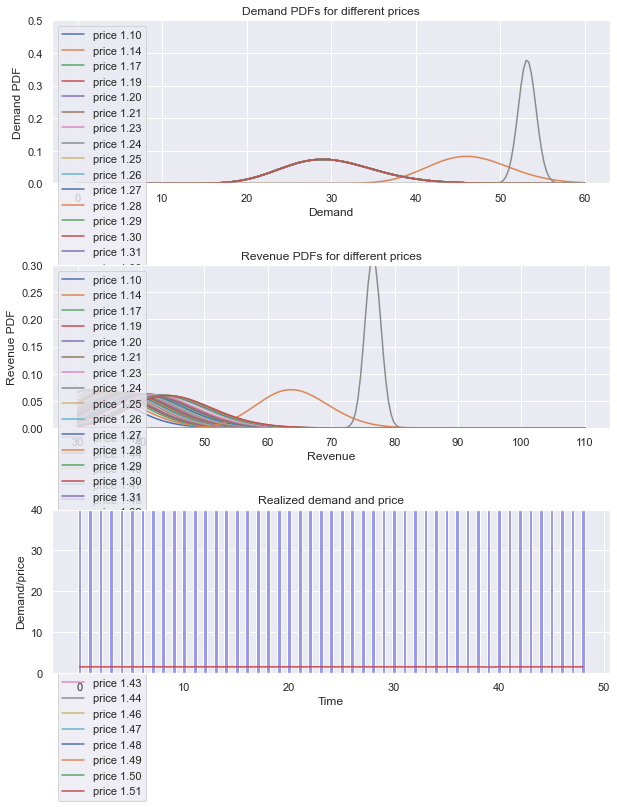

In [38]:
def visualize_snapshot(t):
    plt.subplot(3, 1, 1)
    plt.xlabel('Demand')
    plt.ylabel('Demand PDF')
    plt.title('Demand PDFs for different prices')
    x = np.linspace(0, 60, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.5])
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.xlabel('Revenue')
    plt.ylabel('Revenue PDF')
    plt.title('Revenue PDFs for different prices')
    x = np.linspace(30, 110, 200) 
    for i, params in enumerate(history[t][3]):
        y = stats.gamma.pdf(x, a=params['alpha']*params['price'], scale=1.0/params['beta']) 
        plt.plot(x, y, "-", label='price %.2f' % params['price']) 
    plt.legend(loc='upper left')
    plt.ylim([0, 0.3])
    
    plt.subplot(3, 1, 3)
    plt.xlabel('Time')
    plt.ylabel('Demand/price')
    plt.title('Realized demand and price')
    prices = [h[0] for h in history]
    demands = [h[1] for h in history]
    plt.plot(range(0, t+1), np.array(prices)[0:t+1], 'r-') 
    plt.bar(range(0, T-1), np.pad(np.array(demands)[0:t+1], (0, T-2-t), 'constant'), 0.35, color='#9999ee')
    plt.ylim([0, 40])

fig = plt.figure(figsize = (10, 12))
plt.subplots_adjust(hspace = 0.5)
visualize_snapshot(T - 2)                 # fisualize the final state of the simulation
plt.show()